In [35]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

In [36]:
import functools
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch
import torchtext
import datasets
import tqdm

In [37]:
#使用随机种子：我们的实验都可以得到相同的结果，测量模型的方差
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

In [38]:
train_data,test_data=datasets.load_dataset('imdb',split=['train','test'])

Using the latest cached version of the module from C:\Users\Bingbing\.cache\huggingface\modules\datasets_modules\datasets\imdb\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1 (last modified on Wed Mar  9 16:54:22 2022) since it couldn't be found locally at imdb., or remotely on the Hugging Face Hub.
Reusing dataset imdb (C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
train_data,test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [40]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], id=None)}

In [41]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [42]:
#下面通过分词器将字符的数据转化为数字的形式
tokenizer=torchtext.data.get_tokenizer("basic_english")
tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

['hello',
 'world',
 '!',
 'how',
 'are',
 'you',
 'doing',
 'today',
 '?',
 'i',
 "'",
 'm',
 'doing',
 'fantastic',
 '!']

In [43]:
#使用map的方法将函数应用到dataset类的每个实例中
def tokenize_example(example,tokenizer,max_length):
    tokens=tokenizer(example['text'][:max_length])
    return {'tokens':tokens}

In [44]:
max_length = 256
train_data = train_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
valid_data = test_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

Loading cached processed dataset at C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1\cache-344487d0bdc3745d.arrow
Loading cached processed dataset at C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1\cache-93ec70e4e82ad6ac.arrow


In [45]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [46]:
#使用dataset对象中的train_test_split方法进行分割，具体的使用方法如下：
test_size=0.25
train_valid_data=train_data.train_test_split(test_size=test_size)
train_data=train_valid_data['train']
test_data=train_valid_data['test']

Loading cached split indices for dataset at C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1\cache-155919d1b392c3a5.arrow and C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1\cache-f133bcd25adddba9.arrow


In [47]:
#建立词汇表： <unk>:表示低频词未在词表中的词，<pad>补全字符
min_freq=5
special_tokens=['<unk>','<pad>']
vocab=torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],min_freq=min_freq,specials=special_tokens)

In [48]:
len(vocab)

9679

In [49]:
#直接查看词汇表
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'of', 'i', 'and', "'"]

In [50]:
#让默认的索引和unk_token的索引相同
vocab.set_default_index(vocab['<unk>'])

In [51]:
vocab['some_token']

0

In [52]:
#增加数字的属性，将单词转化为one——hot编码
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

In [53]:
train_data=train_data.map(numericalize_data,fn_kwargs={'vocab':vocab})
valid_data=valid_data.map(numericalize_data,fn_kwargs={'vocab':vocab})
test_data=valid_data.map(numericalize_data,fn_kwargs={'vocab':vocab})

Loading cached processed dataset at C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1\cache-97e26637059f0b26.arrow
Loading cached processed dataset at C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1\cache-05e7650b39a27927.arrow
Loading cached processed dataset at C:\Users\Bingbing\.cache\huggingface\datasets\imdb\plain_text\1.0.0\3209821c5855b9d6c552b4c952dba9c46c354c36e69eacdd07eb70a4bf82f1c1\cache-db4ff06ea7032d45.arrow


In [54]:
train_data[0]

{'text': 'Ya know when one looks at this Brian DePalma film today, I\'m sure there has been allot of criticism about how dated it is. Also, about the violence. When I looked at this film on VHS when I was 20, I thought it was ulta-violent and gritty as well. But I didn\'t get \'it\'.<br /><br />A few decades go by and man, how I know how much I didn\'t get in this film!! This is a remake of an excellent film which was done back in the 30\'s/40\'s. How can you improve upon a classic? Ya don\'t. But you tell a tale that is brought up to date through the eyes of the "new immigrants" during the most greed ridden decade, the over indulgent 80\'s. DePalma, Stone and the gang present an ambitious, disturbing and darn right good film.<br /><br />Yes....Disco was dying and New Wave/Punk were taking over but these immigrants from Cuba who had to make a new home in Florida couldn\'t tell the difference. It was exciting, it was what they wanted but how to get it???? To these immigrants, there was 

In [55]:
#将其转化为tensor的形式
train_data=train_data.with_format(type='torch',columns=['ids','label'])
valid_data=valid_data.with_format(type='torch',columns=['ids','label'])
test_data=test_data.with_format(type='torch',columns=['ids','label'])

In [56]:
train_data[0]

{'label': tensor(1),
 'ids': tensor([4692,  120,   52,   27,  379,   36,   12, 1406, 6980,   19,  512,    4,
            7,    9,  104,  263,   53,   46,   80,    0,    6, 3646,   37,   89,
         1959,   11,   13,    3,  137,    4,   37,    2,  759,    3,   52,    7,
          477,   36,   12,   19,   25, 1224,   52,    7,   17,  806,    4,    7,
          131,   11,   17,    0,    8, 1917,   20,   88,    3,   22,    7, 2218])}

In [57]:
pad_index = vocab['<pad>']
pad_index

1

In [58]:
def collate(batch,pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [59]:
batch_size=512
collate=functools.partial(collate,pad_index=pad_index)
# merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [60]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)
    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [61]:
train_data.unique('label')

[1, 0]

In [62]:
vocab_size=len(vocab)
embedding_dim=300
output_dim=len(train_data.unique('label'))
model=NBoW(vocab_size=vocab_size,embedding_dim=embedding_dim,output_dim=output_dim,pad_index=pad_index)

In [63]:
#模型参数的统计
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,904,302 trainable parameters


In [64]:
vectors=torchtext.vocab.FastText()
pretrained_embedding=vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape

torch.Size([9679, 300])

In [65]:
#将使用fasttext预训练模型作为模型嵌入层的初始的参数权重
model.embedding.weight.data=pretrained_embedding
optimizer=optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss()

In [66]:
#计算accuracy
def binary_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy
def train(model,iterator,optimizer,lossfunction):
    epoch_loss=[]
    epoch_acc=[]
    model.train()
    count=0
    for batch in tqdm.tqdm(iterator,desc='training....',file=sys.stdout):
        ids = batch['ids']
        label = batch['label']
        optimizer.zero_grad()
        prediction=model(ids)
        loss=lossfunction(prediction,label)
        acc=binary_accuracy(prediction,label)
        loss.backward()
        optimizer.step()
        if(count%10==0):
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())

    return epoch_loss , epoch_acc

In [67]:
def eval(model,iterator,lossfunction):
    epoch_loss=[]
    epoch_acc=[]
    model.eval()
    with torch.no_grad():
        count=0
        for batch in tqdm.tqdm(iterator,desc='evaluating....',file=sys.stdout):
            ids = batch['ids']
            label = batch['label']
            optimizer.zero_grad()
            prediction=model(ids)
            loss=lossfunction(prediction,label)
            acc=binary_accuracy(prediction,label)
            count=count+1
            if(count%10==0):
                epoch_loss.append(loss.item())
                epoch_acc.append(acc.item())
    return epoch_loss , epoch_acc

In [84]:
n_epochs = 20
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(iterator=train_dataloader, model=model, lossfunction=criterion, optimizer=optimizer)
    valid_loss, valid_acc = eval(iterator=valid_dataloader, model=model, lossfunction=criterion)

    train_losses=train_losses+train_loss
    train_accs=train_accs+train_acc
    valid_losses=valid_losses+valid_loss
    valid_accs=valid_accs+valid_acc

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), r'D:\Python\Python_Project\Python LSTM\Sentiment Analysis （LSTM　CNN　RNN）\nbow.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating....: 100%|██████████| 49/49 [00:06<00:00,  7.40it/s]
epoch: 1
train_loss: 0.655, train_acc: 0.670
valid_loss: 0.643, valid_acc: 0.672
evaluating....: 100%|██████████| 49/49 [00:06<00:00,  7.47it/s]
epoch: 2
train_loss: 0.610, train_acc: 0.712
valid_loss: 0.603, valid_acc: 0.710
evaluating....: 100%|██████████| 49/49 [00:06<00:00,  7.38it/s]
epoch: 3
train_loss: 0.558, train_acc: 0.749
valid_loss: 0.563, valid_acc: 0.739
evaluating....: 100%|██████████| 49/49 [00:06<00:00,  7.27it/s]
epoch: 4
train_loss: 0.509, train_acc: 0.782
valid_loss: 0.532, valid_acc: 0.754
evaluating....: 100%|██████████| 49/49 [00:07<00:00,  6.85it/s]
epoch: 5
train_loss: 0.468, train_acc: 0.803
valid_loss: 0.510, valid_acc: 0.760
evaluating....: 100%|██████████| 49/49 [00:06<00:00,  7.02it/s]
epoch: 6
train_loss: 0.434, train_acc: 0.823
valid_loss: 0.494, valid_acc: 0.762
evaluating....: 100%|██████████| 49/49 [00:06<00:00,  7.02it/s]
epoch: 7
train_loss: 0.407, train_acc: 0.835
valid_loss: 0.487, va

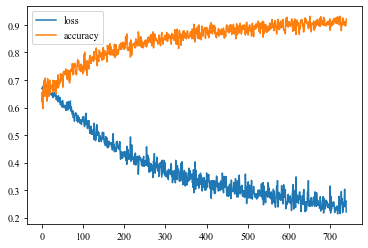

In [96]:
plt.rc('font',family='Times New Roman',size=10)
df = pd.DataFrame(train_losses, columns=['loss'])
df2=pd.DataFrame(train_accs,columns=['accuracy'])
plt.plot(range(len(train_losses)),df['loss'])
plt.plot(range(len(train_accs)),df2['accuracy'])
plt.legend(['loss','accuracy'])

In [89]:
model.load_state_dict(torch.load(r'D:\Python\Python_Project\Python LSTM\Sentiment Analysis （LSTM　CNN　RNN）\nbow.pt'))

test_loss, test_acc = eval(iterator=test_dataloader, model=model, lossfunction=criterion)
epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating....: 100%|██████████| 49/49 [00:06<00:00,  7.44it/s]
test_loss: 0.478, test_acc: 0.773


In [92]:
def predict_sentiment(text, model, tokenizer, vocab):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [93]:
text = "This film is terrible!"
predict_sentiment(text, model, tokenizer, vocab)

(0, 0.9997126460075378)